In [1]:
# install library to get dataset
!pip install datasets --quiet # supress output with --quiet
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# various imports
import datasets
import os
import torch
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from PIL import Image
import cv2
from typing import List, Callable, Optional

In [3]:
# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI')

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [4]:
# get train and test splits
torch_train_ds = dataset['train']
torch_test_ds = dataset['test']

In [5]:
# convert dataset into PyTorch format
train_list = []

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

for i in range(512):
  print(i)
  x = transform(np.array(torch_train_ds['image'][i]))
  y = torch_train_ds['label'][i]
  train_list.append([x, y])

trainloader = DataLoader(train_list, shuffle=True, batch_size=16)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
# same as above but for test set
test_list = []

for i in range(64):
  x = transform(np.array(torch_test_ds['image'][i]))
  y = torch_test_ds['label'][i]
  test_list.append([x, y])

testLoader = DataLoader(test_list, shuffle=True, batch_size=16)

In [7]:
# define CNN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


# GradCAM

In [32]:
# dict for conversion from int to meaningful labels
labels_dict = {0:'Mild Dementia', 1: 'Moderate Dementia', 2: 'No Dementia', 3: 'Very Mild Dementia'}

In [33]:
# label conversion helper function
def tensor_to_label(label_tensor):
  label_num = int(label_tensor)
  return labels_dict[label_num]

In [34]:
# get a set of images for gradcam use from the dataloader
def get_imgs_for_grad_cam(loader):
  gc_imgs, gc_labels = next(iter(loader))
  gc_list = []
  for i in range(16):
    gc_img_tensor = gc_imgs[i]
    gc_img = transforms.ToPILImage()(gc_img_tensor)
    gc_label = gc_labels[i]
    rgb_img = gc_img.convert('RGB')
    img_arr = np.array(rgb_img) / 255
    gc_list.append((img_arr, gc_label))
  return gc_imgs, gc_list

In [35]:
# set up gradcam
model = net
target_layers = [model.conv1, model.conv2]
cam = GradCAM(model=model, target_layers=target_layers)

# generate gradcam visualizations
input_tensor, viz_images_labels = get_imgs_for_grad_cam(trainloader)
grayscale_cam = cam(input_tensor)

# put visualizations on original MRIs and pair with labels
viz_list = []
for i in range(16):
  single_cam = grayscale_cam[i, :]
  visualization = show_cam_on_image(viz_images_labels[i][0], single_cam, use_rgb=True)
  viz_list.append((visualization, viz_images_labels[i][1]))

In [36]:
# get model predictions for each example
predictions = torch.max(net(input_tensor), 1)[1]

Label:Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]],

       [[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]],

       [[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]],

       ...,

       [[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]],

       [[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]],

       [[  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114],
        ...,
        [  0,   0, 114],
        [  0,   0, 114],
        [  0,   0, 114]]], dtype=uint8)
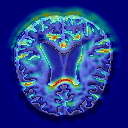

In [37]:
print("Label:" + tensor_to_label(viz_list[0][1]))
print("Predicted Label: " + tensor_to_label(predictions[0]))
viz_list[0][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
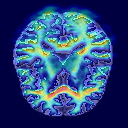

In [38]:
print(tensor_to_label(viz_list[1][1]))
print("Predicted Label: " + tensor_to_label(predictions[1]))
viz_list[1][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]],

       [[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]],

       [[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]],

       ...,

       [[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]],

       [[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]],

       [[ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74],
        ...,
        [ 0,  0, 74],
        [ 0,  0, 74],
        [ 0,  0, 74]]], dtype=uint8)
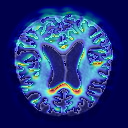

In [39]:
print(tensor_to_label(viz_list[2][1]))
print("Predicted Label: " + tensor_to_label(predictions[2]))
viz_list[2][0]

No Dementia
Predicted Label: No Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
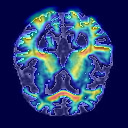

In [40]:
print(tensor_to_label(viz_list[3][1]))
print("Predicted Label: " + tensor_to_label(predictions[3]))
viz_list[3][0]

No Dementia
Predicted Label: No Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
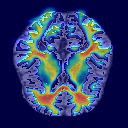

In [41]:
print(tensor_to_label(viz_list[4][1]))
print("Predicted Label: " + tensor_to_label(predictions[4]))
viz_list[4][0]

No Dementia
Predicted Label: No Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
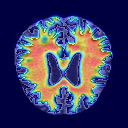

In [42]:
print(tensor_to_label(viz_list[5][1]))
print("Predicted Label: " + tensor_to_label(predictions[5]))
viz_list[5][0]

Mild Dementia
Predicted Label: Mild Dementia


array([[[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]],

       [[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]],

       [[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]],

       ...,

       [[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]],

       [[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]],

       [[128,  74,   0],
        [128,  74,   0],
        [128,  74,   0],
        ...,
        [128,  74,   0],
        [128,  74,   0],
        [128,  74,   0]]], dtype=uint8)
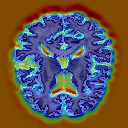

In [43]:
print(tensor_to_label(viz_list[6][1]))
print("Predicted Label: " + tensor_to_label(predictions[6]))
viz_list[6][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]],

       [[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]],

       [[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]],

       ...,

       [[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]],

       [[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]],

       [[  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128],
        ...,
        [  0,  12, 128],
        [  0,  12, 128],
        [  0,  12, 128]]], dtype=uint8)
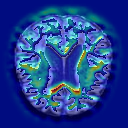

In [44]:
print(tensor_to_label(viz_list[7][1]))
print("Predicted Label: " + tensor_to_label(predictions[7]))
viz_list[7][0]

Mild Dementia
Predicted Label: Mild Dementia


array([[[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]],

       [[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]],

       [[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]],

       ...,

       [[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]],

       [[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]],

       [[118,   0,   0],
        [118,   0,   0],
        [118,   0,   0],
        ...,
        [118,   0,   0],
        [118,   0,   0],
        [118,   0,   0]]], dtype=uint8)
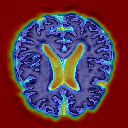

In [45]:
print(tensor_to_label(viz_list[8][1]))
print("Predicted Label: " + tensor_to_label(predictions[8]))
viz_list[8][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
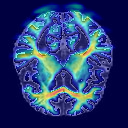

In [46]:
print(tensor_to_label(viz_list[9][1]))
print("Predicted Label: " + tensor_to_label(predictions[9]))
viz_list[9][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
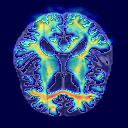

In [47]:
print(tensor_to_label(viz_list[10][1]))
print("Predicted Label: " + tensor_to_label(predictions[10]))
viz_list[10][0]

No Dementia
Predicted Label: No Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
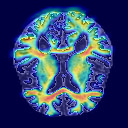

In [48]:
print(tensor_to_label(viz_list[11][1]))
print("Predicted Label: " + tensor_to_label(predictions[11]))
viz_list[11][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]],

       [[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]],

       [[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]],

       ...,

       [[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]],

       [[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]],

       [[104,   0,   0],
        [104,   0,   0],
        [104,   0,   0],
        ...,
        [104,   0,   0],
        [104,   0,   0],
        [104,   0,   0]]], dtype=uint8)
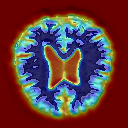

In [49]:
print(tensor_to_label(viz_list[12][1]))
print("Predicted Label: " + tensor_to_label(predictions[12]))
viz_list[12][0]

No Dementia
Predicted Label: No Dementia


array([[[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]],

       [[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]],

       [[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]],

       ...,

       [[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]],

       [[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]],

       [[  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100],
        ...,
        [  0,   0, 100],
        [  0,   0, 100],
        [  0,   0, 100]]], dtype=uint8)
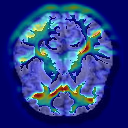

In [50]:
print(tensor_to_label(viz_list[13][1]))
print("Predicted Label: " + tensor_to_label(predictions[13]))
viz_list[13][0]

Very Mild Dementia
Predicted Label: Very Mild Dementia


array([[[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]],

       [[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]],

       [[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]],

       ...,

       [[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]],

       [[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]],

       [[128,   8,   0],
        [128,   8,   0],
        [128,   8,   0],
        ...,
        [128,   8,   0],
        [128,   8,   0],
        [128,   8,   0]]], dtype=uint8)
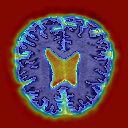

In [51]:
print(tensor_to_label(viz_list[14][1]))
print("Predicted Label: " + tensor_to_label(predictions[14]))
viz_list[14][0]

No Dementia
Predicted Label: No Dementia


array([[[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       ...,

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]],

       [[ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64],
        ...,
        [ 0,  0, 64],
        [ 0,  0, 64],
        [ 0,  0, 64]]], dtype=uint8)
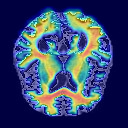

In [52]:
print(tensor_to_label(viz_list[15][1]))
print("Predicted Label: " + tensor_to_label(predictions[15]))
viz_list[15][0]